# Prediction of Nighttime NO2

## Background

### Names and Acronyms
1) ASDC: [Atmosperhic Science Data Center](https://asdc.larc.nasa.gov/about)
1) PGN (Pandora): [Pandonia Global Network](https://www.pandonia-global-network.org/) / [Pandora](https://pandora.gsfc.nasa.gov/About/)
    - **NOTE**: NASA's portion of the PGN is known as Pandora.  Within the scope of this notebook, Pandora and PGN may be used interchangably as this project will only use NASAs PGN site data.
1) TEMPO: [Troposoperic Emissions: Monitoring of Pollution](https://science.nasa.gov/mission/tempo/)

### Resources
1) ASDC Data Processing Tool (Version 1)
    - This notebook was published by the ASDC and provides examples of how to correctly load and use Pandora and TEMPO data.
    - https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb
1) PGN Station Map
    - A map showing the location of all PGN groundsites.
    - https://blickm.hetzner.pandonia-global-network.org/livemaps/pgn_stationsmap.png


This notebook borrows heavily from and extens the functionality of the NASA, ASDC Data and User Servicies notebook found here:

https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb

This notebook intends to test the hypothesis that a model can be built with Pandora which can predict nightitme NO<sub>2</sub> and that that model can be applied to TEMPO daytime measurments to predict NO<sub>2</sub> for any location covered by TEMPO.



## 1. Environment Setup

### Environment Setup
There are many tools available such as [poetry](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://python-poetry.org/&ved=2ahUKEwjr9aLgna6QAxX5EVkFHVsNBMUQFnoECBsQAQ&usg=AOvVaw3Jp8q7OO7XkcY8Tq4tDe30) and [uv](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://docs.astral.sh/uv/&ved=2ahUKEwiP9aXVna6QAxVyF1kFHeyTNGYQFnoECAsQAQ&usg=AOvVaw2VJVt0jrah2S9tIgdc1yRc) that simplify and speed up environment setup.  For simplicity, this guide only covers the method built into the python standard library.
1) Install [Python 3.11](https://www.python.org/downloads/) (or higher)
1) (Recomended) Create a virtual environment (learn more [here](https://docs.python.org/3/library/venv.html))
1) Install the required packages using the following command.<br>`% pip install pyproject.toml`
1) Select the newly created kernal in your notebook.
    - NOTE: this varies slightly between notebook tools, but in almost all tools you will be prompted to select a kernal upon running a cell.

### Import required modules

Common imports that are used throughout.  Other packages will be imported as needed.

In [9]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

### Data Access
In order to access data, you will need an Earthdata Login account.  If you do not have an Earthdata Login account, you can create one here:<br>
https://urs.earthdata.nasa.gov/

The earthaccess module allows you to authenticate.  Multilple login options exist for providing your credentials, you can read more on options here:<br>
https://pypi.org/project/earthaccess/<br>
By unless another option is configured, you will be prompted by your notebook to enter your credentials.

In [10]:
import earthaccess


earthaccess.login()

Notebook Settings

In [11]:
PGN_DATA_DIR = Path('pgn-data')
PGN_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
PGN_DATA_PATH = PGN_DATA_DIR.joinpath('pgn-data.csv')
TEMPO_DATA_DIR = Path('tempo-data')
TEMPO_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
TEMPO_DATA_PATH = TEMPO_DATA_DIR.joinpath('tempo-data.csv')

## 1. Data Prepairation

### 1.1. Download Data

**Data Ingest Workflow**
1) Collect the URLs for relivant files.
1) If not already downloaded, download the files.
1) If not already parsed, parse the files and save them as dataframes.
1) Return a list of relivant file paths

**Notes**
- PGN and TEMPO files are saved to the PGN_DATA_DIR and TEMPO_DATA_DIR directories.
- This system allows new files to be added while old files are still used, when available.
- TEMPO files are VERY large, a full year of data for 3 PGN sites takes up 100GB of hard drive space.
- Running for a shorter time period does not delete data, it only uses a smaller subset of files ensuring that short time frames can be used for testing.
- Though VERY slow to run initially, subsiquent runs for the same or smaller data subsets are fairly fast.

#### 1.1.1. Define Download Settings

In [ ]:
start_date = datetime(2024, 7, 1)
end_date = datetime(2024, 7, 7)

#### 1.1.1. Download Pandora data

Pandora settings

In [13]:
pgn_suffix = "rnvh3p1-8.txt"
no2_quality_flag_index = 52
valid_quality_flags = [0, 10]
column_index = 61
column_unc_index = 62
sites = ['BronxNY', 'BuffaloNY', 'QueensNY']
sites_url = "https://data.pandonia-global-network.org"

Get relivant PGN files.  Site data files can be found manually here: https://data.pandonia-global-network.org/

In [14]:
import requests


def get_page_links(url: str):
    """
    An tool for getting all PGN links from a PGN data webpage (https://data.hetzner.pandonia-global-network.org/)

    ARGS:
        url (str): The URL of the page to extract links form
    """
    things_to_remove = [
        '<span class="name">',
        '</span>',
        '/</span>'
    ]

    response = requests.get(url)
    assert response.status_code==200, f"Download failed with code {response.status_code}"
    
    # get item name lines
    names = [l.strip() for l in response.text.splitlines()]
    names = [l for l in names if l.startswith('<span class="name">')]

    # get item names from name lines
    for thing_to_remove in things_to_remove:
        names = [l.replace(thing_to_remove, '') for l in names]
        names = [l.rstrip('/') for l in names]

    return names


# get file URLs
print("Getting File URLs")
pgn_urls: list[str] = []
for i, site in enumerate(sites):
    site_url = f"{sites_url}/{site}"
    instruments = get_page_links(site_url)
    print(f"Site {i+1} of {len(sites)}:", site)
    for j, instrument in enumerate(instruments):
        print(f"\tInstrument {j+1} of {len(instruments)}:", instrument)
        file_url = f"{site_url}/{instrument}/L2/{instrument}_{site}_L2_{pgn_suffix}"
        pgn_urls.append(file_url)

print("File URLs:")
for pgn_url in pgn_urls:
    print(f"\t{pgn_url}")

Getting File URLs
Site 1 of 3: BronxNY
	Instrument 1 of 2: Pandora147s1
	Instrument 2 of 2: Pandora180s1
Site 2 of 3: BuffaloNY
	Instrument 1 of 1: Pandora206s1
Site 3 of 3: QueensNY
	Instrument 1 of 1: Pandora55s1
File URLs:
	https://data.pandonia-global-network.org/BronxNY/Pandora147s1/L2/Pandora147s1_BronxNY_L2_rnvh3p1-8.txt
	https://data.pandonia-global-network.org/BronxNY/Pandora180s1/L2/Pandora180s1_BronxNY_L2_rnvh3p1-8.txt
	https://data.pandonia-global-network.org/BuffaloNY/Pandora206s1/L2/Pandora206s1_BuffaloNY_L2_rnvh3p1-8.txt
	https://data.pandonia-global-network.org/QueensNY/Pandora55s1/L2/Pandora55s1_QueensNY_L2_rnvh3p1-8.txt


Download files (if needed)

In [15]:
# Download Files
pgn_files: list[Path] = []
print(f"Downloading pgn files to {PGN_DATA_DIR}")
for i, pgn_url in enumerate(pgn_urls):
    file_name = Path(pgn_url).name
    file_path = PGN_DATA_DIR.joinpath(file_name)
    if file_path.exists():
        print(f"File {i+1} of {len(pgn_urls)} exists and will not be downloaded: {file_name}")
    else:
        print(f"\tDownloading file {i+1} of {len(pgn_urls)}: {file_name}")
        response = requests.get(pgn_url)
        file_path.write_bytes(response.content)
    pgn_files.append(file_path)
print("Files downloaded")

File 1 of 4 exists and will not be downloaded: Pandora147s1_BronxNY_L2_rnvh3p1-8.txt
File 2 of 4 exists and will not be downloaded: Pandora180s1_BronxNY_L2_rnvh3p1-8.txt
File 3 of 4 exists and will not be downloaded: Pandora206s1_BuffaloNY_L2_rnvh3p1-8.txt
File 4 of 4 exists and will not be downloaded: Pandora55s1_QueensNY_L2_rnvh3p1-8.txt
Files downloaded


Parse files into CSV format (if needed)

In [ ]:
# PGN format settings (these should not change)
pgn_section_delim = f"{'-'*87}\n"
header_delim = ": "
pgn_loc_key = "Short location name"
pgn_lat_key = "Location latitude [deg]"
pgn_lon_key = "Location longitude [deg]"
# Avogadro constant divided by 10000
no2_scale = 6.02214076E+19

sites = []
lats = []
lons = []
PGN_PATHS = []

# build the final dataset
print("Parsing PGN data started")
for i, pgn_path in enumerate(pgn_files):
    # get file sections as lines
    text = pgn_path.read_text()
    metadata_text, column_text, data_text = text.split(pgn_section_delim)
    metadata_lines = metadata_text.splitlines()
    data_lines = data_text.splitlines()

    # get metadata
    metadata = {}
    for line in metadata_lines:
        key, value = line.split(header_delim)
        metadata[key] = value
    
    site_lat = float(metadata[pgn_lat_key])
    site_lon = float(metadata[pgn_lon_key])

    sites.append(pgn_path.name.split('_')[1])
    lats.append(site_lat)
    lons.append(site_lon)

    # if data already exists as CSV, skip parsing
    csv_path = pgn_path.with_suffix('.csv')
    if csv_path.exists():
        PGN_PATHS.append(csv_path)
        continue

    # get data
    rows = []
    for line in data_lines:
        values = line.split()
        # convert timestamps
        timestamp = datetime.fromisoformat(values[0]).replace(tzinfo=None)

        # filtering low quality records
        if int(values[no2_quality_flag_index]) not in valid_quality_flags:
            continue

        row = {
            'Time': timestamp,
            'Latitude': site_lat,
            'Longitude': site_lon,
            'Column': float(values[61])*no2_scale,
            'Uncertainty': float(values[62])*no2_scale,
            'Site': metadata[pgn_loc_key],
        }
        rows.append(row)

    # convert rows into a dataframe
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(csv_path, index=False)
        PGN_PATHS.append(csv_path)
    print(f"\tValid Observations: {len(rows)}")

# create site metadata dataframe
sites_df = pd.DataFrame({
    'Site': sites,
    'Latitude': lats,
    'Longitude': lons
}).set_index('Site')

print("Parsing", len(PGN_PATHS), "PGN files")
sites_df


Parsing PGN data started
	Valid Observations: 0
Parsing 3 PGN files


,Latitude,Longitude
Site,,
BronxNY,40.8679,-73.8781
BronxNY,40.8679,-73.8781
BuffaloNY,43.0015,-78.7869
QueensNY,40.7361,-73.8215


Get latitudes and longitudes (for use with TEMPO download)

#### 1.1.1 Download TEMPO Data

Get relivant TEMPO files.

In [ ]:
short_name = 'TEMPO_NO2_L2' # collection name to search for in the EarthData
out_Q = 'NO2_trop_col_day'
version = 'V03'

cloud_files = []
for site, site_lat, site_lon in sites_df.itertuples():
    cloud_files += earthaccess.search_data(
        short_name = short_name,
        version = version,
        temporal = (start_date, end_date),
        point = (site_lon, site_lat)
    )

print("Found", len(cloud_files), "data collections containing the sites.")

Found 1575 data collections containing the sites.


Download files (if needed)

In [18]:
import warnings

# this error comes from netCDF4 and is only a warning and can be ignored
warnings.filterwarnings(
    "ignore",
    message="__array__ implementation doesn't accept a copy keyword",
    category=DeprecationWarning,
)

nc_paths: list[Path] = []
for i, cloud_file in enumerate(cloud_files):
    # download files if a file with the same name is not found in the download directory
    paths = earthaccess.download(cloud_file, local_path=TEMPO_DATA_DIR, show_progress=False)
    nc_paths += paths

print("Downloaded", len(nc_paths), "files.")

Downloaded 1575 files.


Parse TEMPO files into CSV format (if needed)

In [ ]:
import netCDF4 as nc

# only keep measurments within offset of a site
offset = 0.1

TEMPO_FILES = []
col_names = ['Time', 'Latitude', 'Longitude', 'Column', 'Uncertainty', 'Site', 'System']

for path in nc_paths:
    csv_path = path.with_suffix('.csv')
    # skip if file already exists
    if csv_path.exists():
        TEMPO_FILES.append(csv_path)
        continue

    file_time = datetime.fromisoformat(path.name.split('_')[4]).replace(tzinfo=None)
    with nc.Dataset(path) as ds:
        geolocation = ds['geolocation']
        product = ds['product']
        col_var = product['vertical_column_troposphere']
        unc_var = product['vertical_column_troposphere_uncertainty']

        col_fil = col_var.getncattr('_FillValue')
        unc_fil = unc_var.getncattr('_FillValue')

        lats = np.array(geolocation['latitude']).flatten()
        lons = np.array(geolocation['longitude']).flatten()
        cols = np.array(col_var).flatten()
        uncs = np.array(unc_var).flatten()

    num_records = len(lats)
    times = np.full((num_records), fill_value=file_time)
    sites = np.full((num_records), fill_value=np.nan)
    systems = np.full((num_records), fill_value='TEMPO')

    data = {
        'Time': times,
        'Latitude': lats,
        'Longitude': lons,
        'Column': cols,
        'Uncertainty': uncs,
    }
    df = pd.DataFrame(data)

    df.to_csv(csv_path, index=False)
    TEMPO_FILES.append(csv_path)

print("Parsed", len(TEMPO_FILES), "files.")

(268288, 5)
(0, 5)
Parsed 0 files.


PGN_FILES and TEMPO_FILES have been populdated with analysis ready data.

### 1.2. Explore Data

After download, analysis ready data must be loaded from CSVs into TEMPO and PGN data dataframs.  Once in dataframes, data can be explored, cleaned, and transformed to ready it for modeling.

#### 1.2.1 Load Pandora

Load Pandora Data

In [20]:
pgn_df = pd.concat([pd.read_csv(p) for p in PGN_PATHS], ignore_index=True)
print("PGN Data Shape:", pgn_df.shape)
pgn_df.head()


PGN Data Shape: (42626, 6)


,Time,Latitude,Longitude,Column,Uncertainty,Site
0,2021-06-29 15:46:24.100,40.8679,-73.8781,1.005035e+16,1.096933e+14,BronxNY
1,2021-06-29 16:17:44.600,40.8679,-73.8781,1.198105e+16,1.146616e+14,BronxNY
2,2021-06-29 16:28:02.500,40.8679,-73.8781,1.059535e+16,1.080071e+14,BronxNY
3,2021-06-29 16:38:25.600,40.8679,-73.8781,7.392780e+15,9.193400e+13,BronxNY
4,2021-06-29 16:51:30.200,40.8679,-73.8781,7.399404e+15,9.154256e+13,BronxNY


#### Load TEMPO

In [21]:
raise Exception("This function takes too long to run")
# select the number of samples to take (as data gets far too large to process on a single machine)
samples_to_take = 10,000
tempo_df = pd.concat([pd.read_csv(p, engine="pyarrow").sample(samples_to_take) for p in TEMPO_FILES], ignore_index=True)
print("TEMPO Data Shape:", tempo_df.shape)
tempo_df.head()

Exception: This function takes too long to run

In [ ]:
# tempo_df.to_csv(TEMPO_DATA_PATH)

#### Explore PGN

In [ ]:
import seaborn as sns


sns.lineplot(data=pgn_df, x='Column', y='Time')

KeyboardInterrupt: 

### 1.3. Clean Data

#### 1.3.1 Clean Pandora 

**Future Work**<br>
For now I only use raw data with outliers removed.  Consider performing the following steps to further normalize datasets.
1) Seasonal Composition
1) Standardized Data

In [ ]:
def get_outlier_mask(column: pd.Series) -> pd.Series:
    """
    Returns a mask where outliers are False for use in filtering outliers.
    Outliers are defined as more than 3 standard deviations from the mean.
    Intended for use in filtering out outliers.
    use: 
        mask = get_outlier_mask(df.ColumnOfIntrest)
        df = df[mask]

    ARGS:
        column (pd.Series[float]): the column to build a mask for
    
    RETURN
        pd.Series[bool]: A mask of the outliers
    """
    col_std = column.std()
    col_mean = column.mean()
    min_cutoff = col_mean - (3 * col_std)
    max_cutoff = col_mean + (3 * col_std)
    return (min_cutoff < column) & (column < max_cutoff)

Raw Data Cleaning

In [ ]:
col_mask = get_outlier_mask(pgn_data.Column)
unc_mask = get_outlier_mask(pgn_data.Uncertainty)
mask = col_mask & unc_mask

print("Filtering", sum(~mask), "rows of", len(mask), f"due to outliers, {round(sum(~mask)/len(mask)*100)}%")
pgn_clean_data = pgn_data[mask]
pgn_clean_data.head()

Filtering 346 rows of 13377 due to outliers, 3%


,Time,Latitude,Longitude,Location,Column,Uncertainty
0,1719842046,43.0015,-78.7869,BuffaloNY,7.549356e+14,1.135294e+14
1,1719845527,43.0015,-78.7869,BuffaloNY,7.286790e+14,1.090429e+14
2,1719847150,43.0015,-78.7869,BuffaloNY,4.645178e+14,1.056524e+14
3,1719848121,43.0015,-78.7869,BuffaloNY,6.737571e+14,1.039542e+14
4,1719849090,43.0015,-78.7869,BuffaloNY,4.410074e+14,1.003108e+14


#### 1.3.2 Clean TEMPO

### 1.4. Transform Data

In [ ]:
col_mask = get_outlier_mask(tempo_data.Column)
unc_mask = get_outlier_mask(tempo_data.Uncertainty)
mask = col_mask & unc_mask

print("Filtering", sum(~mask), "rows of", len(mask), f"due to outliers, {round(sum(~mask)/len(mask)*100)}%")
tempo_clean_data = tempo_data[mask]
tempo_clean_data.head()

Filtering 122548 rows of 4472012 due to outliers, 3%


,Time,Latitude,Longitude,Column,Uncertainty
0,1.403866e+09,58.582800,-64.220375,5.018798e+14,1.366402e+14
1,1.403866e+09,58.536476,-64.263855,6.264613e+14,2.370017e+14
2,1.403866e+09,58.496826,-64.299690,6.328754e+14,2.307473e+14
3,1.403866e+09,58.458267,-64.334200,3.225646e+14,3.939703e+14
4,1.403866e+09,58.421070,-64.367096,2.493699e+14,2.303265e+14


Compare clean data

In [ ]:
clean_compare_df = pgn_clean_data[['Column', 'Uncertainty']].describe().join(
    tempo_clean_data[['Column', 'Uncertainty']].describe(),
    lsuffix='_PGN',
    rsuffix='_TEMPO'
)
clean_compare_df

,Column_PGN,Uncertainty_PGN,Column_TEMPO,Uncertainty_TEMPO
count,1.303100e+04,1.303100e+04,4.349464e+06,4.349464e+06
mean,5.773519e+15,9.517311e+13,1.092413e+15,1.106714e+15
std,4.212874e+15,2.234539e+13,1.393054e+15,9.597021e+14
min,-9.081990e+15,3.743784e+13,-5.380277e+15,1.066555e+14
25%,2.513069e+15,7.985961e+13,2.308500e+14,5.281086e+14
50%,4.743219e+15,9.366838e+13,7.939537e+14,7.705515e+14
75%,7.877863e+15,1.073386e+14,1.648714e+15,1.267311e+15
max,2.237526e+16,1.823444e+14,7.897732e+15,6.365967e+15


Git differences between raw and clean data comparison

In [ ]:
raw_compare_df

,Column_PGN,Uncertainty_PGN,Column_TEMPO,Uncertainty_TEMPO
count,1.337700e+04,1.337700e+04,4.472012e+06,4.472012e+06
mean,6.289382e+15,9.779774e+13,1.257430e+15,1.291481e+15
std,5.370501e+15,2.841439e+13,2.213436e+15,1.691506e+15
min,-1.635613e+16,3.743784e+13,-1.166274e+17,1.066555e+14
25%,2.565372e+15,8.028718e+13,2.362738e+14,5.334135e+14
50%,4.886726e+15,9.432479e+13,8.152280e+14,7.879533e+14
75%,8.262979e+15,1.087478e+14,1.723481e+15,1.346081e+15
max,5.084433e+16,4.669327e+14,2.927148e+17,2.446642e+17


In [ ]:
clean_compare_df

,Column_PGN,Uncertainty_PGN,Column_TEMPO,Uncertainty_TEMPO
count,1.303100e+04,1.303100e+04,4.349464e+06,4.349464e+06
mean,5.773519e+15,9.517311e+13,1.092413e+15,1.106714e+15
std,4.212874e+15,2.234539e+13,1.393054e+15,9.597021e+14
min,-9.081990e+15,3.743784e+13,-5.380277e+15,1.066555e+14
25%,2.513069e+15,7.985961e+13,2.308500e+14,5.281086e+14
50%,4.743219e+15,9.366838e+13,7.939537e+14,7.705515e+14
75%,7.877863e+15,1.073386e+14,1.648714e+15,1.267311e+15
max,2.237526e+16,1.823444e+14,7.897732e+15,6.365967e+15


Filtering did not change the disparity between Uncertainty, it cannot be considered for now.  TEMPO numbers seem to be consistantly a bit lower, but this may be due to the fact that TEMPO data is only collected durrind daylight hours.  For now I will use both to build a model.

**Future Work**
Investigate difference in PGN and TEMPO readings.

## 2. Data Modeling

### 2.1 Data Prep

In [ ]:
all_data = pd.concat([pgn_clean_data, tempo_clean_data])
all_data.head()

,Time,Latitude,Longitude,Location,Column,Uncertainty
0,1.719842e+09,43.0015,-78.7869,BuffaloNY,7.549356e+14,1.135294e+14
1,1.719846e+09,43.0015,-78.7869,BuffaloNY,7.286790e+14,1.090429e+14
2,1.719847e+09,43.0015,-78.7869,BuffaloNY,4.645178e+14,1.056524e+14
3,1.719848e+09,43.0015,-78.7869,BuffaloNY,6.737571e+14,1.039542e+14
4,1.719849e+09,43.0015,-78.7869,BuffaloNY,4.410074e+14,1.003108e+14


In [ ]:
all_data.describe()

,Time,Latitude,Longitude,Column,Uncertainty
count,4.362495e+06,4.362495e+06,4.362495e+06,4.362495e+06,4.362495e+06
mean,1.404901e+09,3.533997e+01,-7.798717e+01,1.106396e+15,1.103693e+15
std,1.831755e+07,1.135126e+01,3.389115e+00,1.432855e+15,9.598571e+14
min,1.403866e+09,1.733732e+01,-8.383506e+01,-9.081990e+15,3.743784e+13
25%,1.403876e+09,2.550596e+01,-8.045638e+01,2.325918e+14,5.263882e+14
50%,1.403890e+09,3.436251e+01,-7.847244e+01,7.975274e+14,7.687020e+14
75%,1.403908e+09,4.451519e+01,-7.622627e+01,1.658236e+15,1.264721e+15
max,1.760807e+09,5.863553e+01,-6.396864e+01,2.237526e+16,6.365967e+15


Convert time to Time of Day

In [ ]:
seconds_per_day = 86400
seconds_since_start_of_day = all_data.Time % seconds_per_day
all_data['TimeOfDay'] = seconds_since_start_of_day.astype(int)

For simplicity (and due to a file format issue that can be fixed later), times will be ignored.

**Future Work**<br>
Use time of day as a feature

Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_cols = ['Time', 'Latitude', 'Longitude']
X = all_data[X_cols]
y = all_data['Column']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### 2.2 Train Models

In [ ]:
from sklearn.linear_model import LinearRegression


# train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 2.2 Test Models

In [ ]:
from sklearn.metrics import mean_squared_error


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error (MSE): {np.sqrt(mse):.2e}")

Root Mean Squared Error (MSE): 1.38e+15


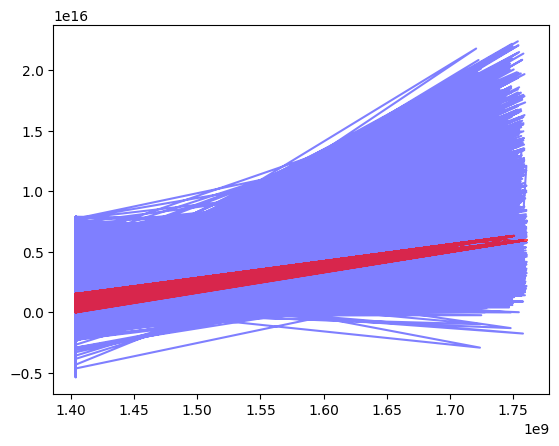

: 

In [ ]:
# --- 7. Plotting Results (Actual vs. Predicted) ---
from matplotlib import pyplot as plt



# Plot training data
plt.plot(X_test.Time, y_test, color='blue', alpha=0.5, label='Training Data (y_train)')

# Plot testing data
plt.plot(X_test.Time, y_pred, color='red', alpha=0.7, label='Testing Data (y_test)')

### 2.3. Model Visualization